# Deffaunt-Weisbuch Model with Heterogeneous Activation Probability
## Author: Grace Li
## Created On: 11/15/2021

This python code combines the generated matfiles from parallel computations and plots the node-level results for visualization.

In [1]:
# import required packages  

import numpy as np
import pandas as pd
from scipy import io, stats
import os
import random
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns
import time as time
import igraph as igraph

# Import our own DW module
import sys
sys.path.append('..') #look one directory above
import DW as DW


In [2]:
#Experiment Parameters
graph_type = "complete"
distribution = "Uniform"
# distribution = "Pareto-90-10"
n = 500

experiment = graph_type + str(n) + "/" + distribution #savefolder name for experiment

#specify confidence radii ds and compromise parameters mus
'''
NOTE: THE CONFIDENCE RADIUS IS CALLED d HERE, BUT c IN THE PAPER
NOTE: THE COMPROMISE PARAMETER IS CALLED mu HERE, BUT m IN THE PAPER
'''

ds = [0.1, 0.3, 0.5, 0.7, 0.9]
# ds = [0.1, 0.3, 0.5]

mus = [0.1, 0.3, 0.5]
# mus = [0.3, 0.5]

#Weight and opinion sets
opinion_sets = list(range(10))
weight_sets = list(range(10))

In [3]:
# #Read the stored matfiles and create a pandas dataframe of simulation results at the node level for each run

filename = experiment + '/combined_matfiles/node_level_results.csv'

#Check to see if we've generated this node-level results dataframe already and load it
try:
    df = pd.read_csv(filename)
    print('Node level results read from file')

#If not, the generate and store the dataframe
except:

    #Assemble the results into a dataframe row
    columns = ['d', 'mu', 'weight_set', 'opinion_set', 'node',
               'normalized_weight', 'cluster_size',
               'init_opinion', 'final_opinion',
               'net_change', 'total_change', 'n_updates', 
               'local_agreement', 'local_receptiveness']

    #Initialize the dataframe
    df = pd.DataFrame(columns = columns)

    for d in ds:
        for mu in mus:
            print('d =', d, ' and mu = ', mu)

            for opinion_set in opinion_sets:
                for weight_set in weight_sets:

                    #Try loading saved matfile
                    matfile = (experiment + '/matfiles/d' + str(d) + '-mu' + str(mu) 
                               + '-weight' + str(weight_set) + '-op' + str(opinion_set) + '.mat')
                    try:
                        results = io.loadmat(matfile)

                        #Get the cluster size of the final opinion cluster each node is in
                        n_clusters = results['n_clusters'][0][0]
                        #If we reached the bailout time, and there's no clusters found then we set everything to NaN
                        if n_clusters == 0:
                            cluster_sizes = [np.nan] * n
                        #If we sucessfully determined the clusters, then we extract which cluster each node is in
                        else:
                            cluster_sizes = np.zeros(n)
                            for i in range(n_clusters):
                                key = "cluster" + str(i)
                                cluster = results[key][0]
                                cluster_sizes[cluster] = len(cluster)

                        #Construct a dataframe with the results for each node from a single run
                        dictionary = {
                                        'd': [d] * n,
                                        'mu': [mu] * n,
                                        'weight_set': [weight_set] * n,
                                        'opinion_set': [opinion_set] * n,
                                        'node': list(range(n)),
                                        'cluster_size' : cluster_sizes,
                                        'init_opinion': results['init_opinions'][0],
                                        'final_opinion': results['final_opinions'][0],
                                        'net_change' : np.abs(results['final_opinions'][0] - results['init_opinions'][0]),
                                        'total_change': results['total_change'][0],
                                        'n_updates': results['n_updates'][0],
                                        'local_agreement': results['local_agreement'][0],
                                        'local_receptiveness': results['local_receptiveness'][0]                    
                                    }
                        if distribution != "Uniform":
                            dictionary['normalized_weight'] = results['weights'][0] / np.sum(results['weights'][0]),

                        #Append the data to the total dataframe
                        run_df = pd.DataFrame(data=dictionary) 
                        df = df.append(run_df, ignore_index=True)

                    except:
                        print("file not found: " + matfile)

    df.to_csv(filename, index=False, header=True)

Node level results read from file


In [4]:
#Generate correlaton matrix
corrMatrix = df.corr()
corrMatrix

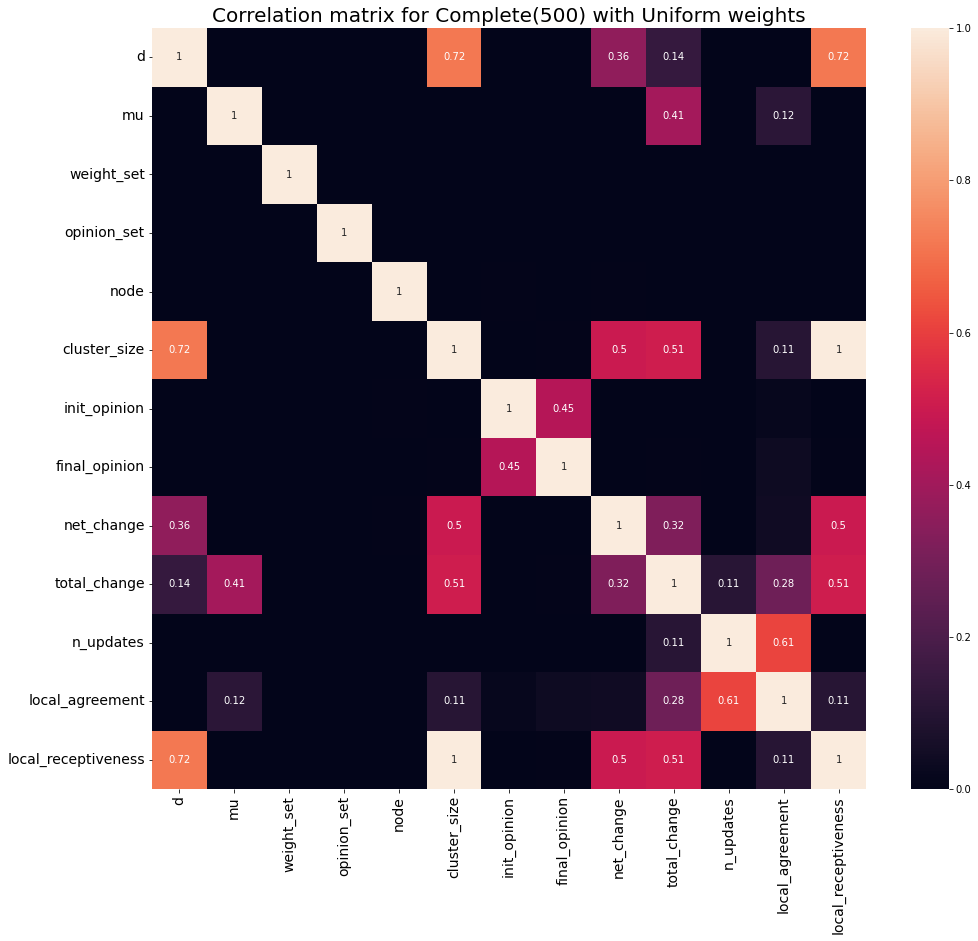

In [6]:
#Check that a directory exists, and if not, create it
directory = experiment + "/plots/node_results/"
if not os.path.exists(directory):
    os.makedirs(directory)

#Plot correlation matrix
fontsizes = {'s': 10, 'm': 14, 'l':20}
fig, ax = plt.subplots(figsize = (16, 14), facecolor='white')

# Don't display values where the correlation coefficient is too small
mask = np.zeros_like(corrMatrix)
mask[np.where(corrMatrix < 0.1)] = True

#Generate heatmap
sns.heatmap(corrMatrix, cbar=False, ax=ax, vmin=0, vmax=1)
sns.heatmap(corrMatrix, mask=mask, ax=ax, cbar=True, annot=True, vmin=0, vmax=1, fmt="1.2g",annot_kws={"size":fontsizes['s']})

#Set axis labels, title and fontsize
cbar = ax.collections[1].colorbar #second plot (index=1) has the colorbar
cbar.ax.tick_params(labelsize=fontsizes['s'])
ax.tick_params(labelsize=fontsizes['m'])
title = "Correlation matrix for Complete(" + str(n) + ") with " + distribution + " weights"
ax.set_title(title, fontsize = fontsizes['l'])

#Save the plot
savefile = directory + "correlation_matrix.png"
plt.savefig(savefile, bbox_inches='tight', facecolor='white')

# #Generate heatmap
# fig, ax = plt.subplots(figsize = (14, 12), facecolor='white')
# sns.heatmap(corrMatrix, annot=True, vmin=0 , vmax=1, fmt="1.2g",annot_kws={"size":fontsizes['s']})

# #Set axis labels, title and fontsize
# cbar = ax.collections[0].colorbar
# cbar.ax.tick_params(labelsize=fontsizes['s'])
# ax.tick_params(labelsize=fontsizes['m'])
# title = "Correlation matrix for Complete(" + str(n) + ") with " + distribution + " weights"
# ax.set_title(title, fontsize = fontsizes['l'])

# #Save the plot
# savefile = directory + "correlation_matrix.png"
# plt.savefig(savefile, bbox_inches='tight', facecolor='white')


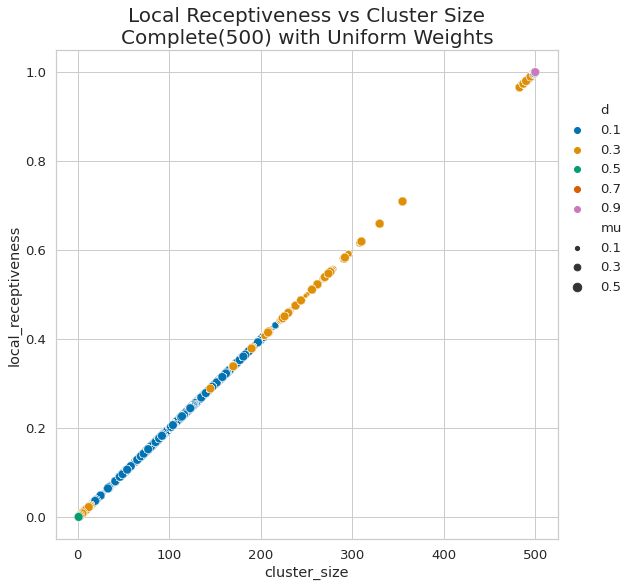

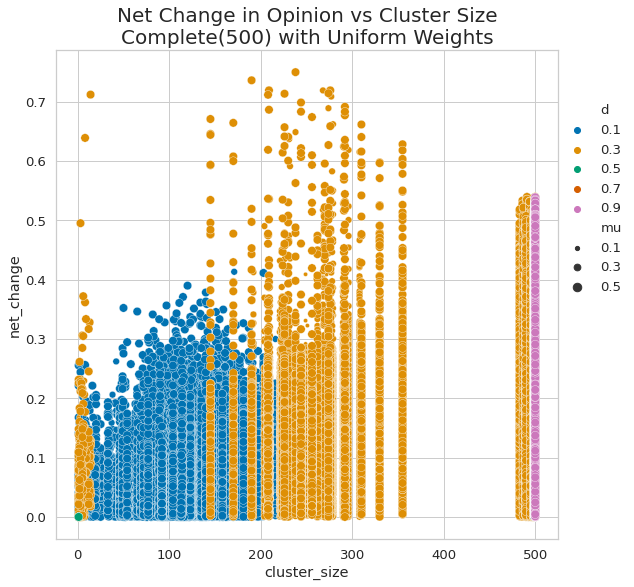

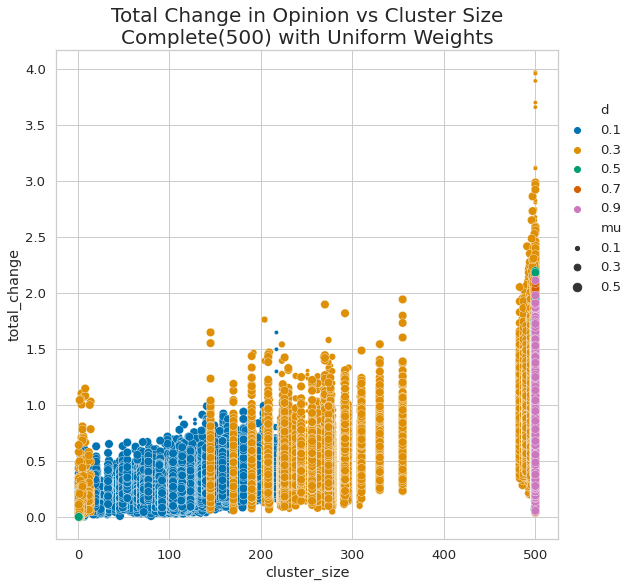

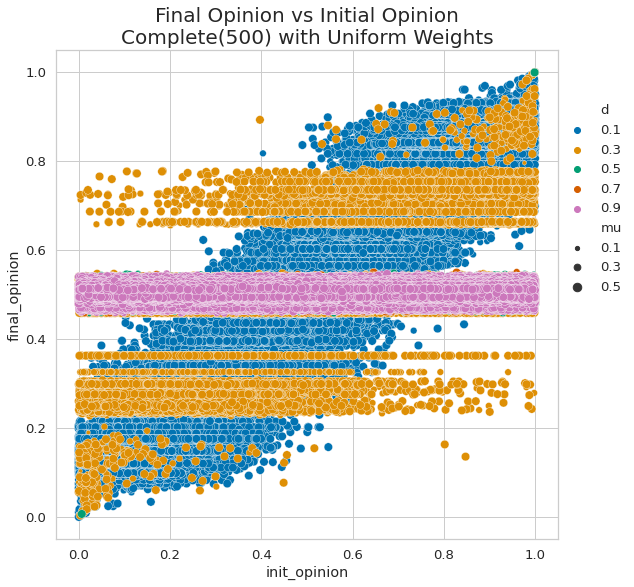

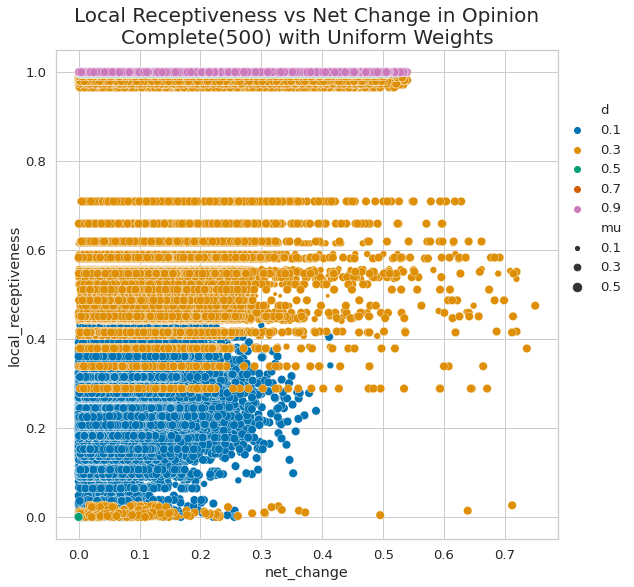

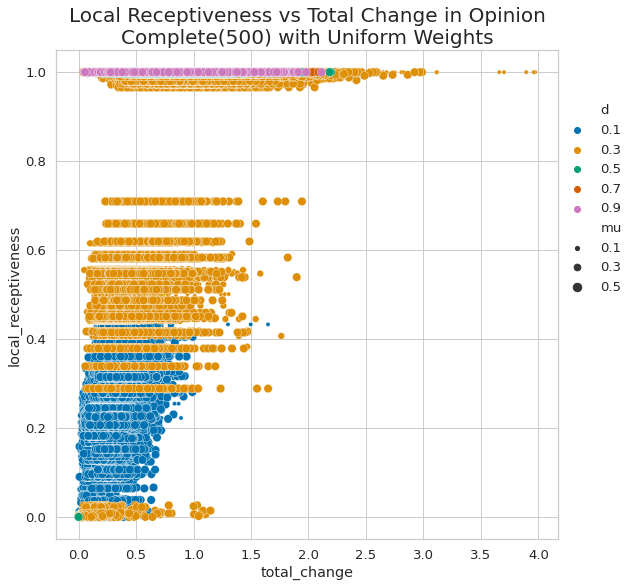

In [7]:
## Generate scatter plots to investigate the higher correlation pairs

label_names = {'d': 'd', 'mu': 'mu', 'cluster_size': 'Cluster Size',
               'init_opinion': 'Initial Opinion', 'final_opinion': 'Final Opinion',
               'net_change': 'Net Change in Opinion', 'total_change': 'Total Change in Opinion',
               'normalized_weight': 'Normalized Node Weight',
               'local_agreement': 'Local Agreement', 'local_receptiveness': 'Local Receptiveness'}

x_vars = ['cluster_size', 'cluster_size', 'cluster_size', 'init_opinion', 'net_change', 'total_change']
y_vars = ['local_receptiveness', 'net_change', 'total_change', 'final_opinion', 'local_receptiveness', 'local_receptiveness']
if distribution != 'Uniform':
    x_vars.append('normalized_weight')
    y_vars.append('total_change')


#Change theme to white
sns.set_theme(style="whitegrid", font_scale = 1.2)

for i in range(len(x_vars)):

    #Make a new figure
    fig, ax = plt.subplots(figsize=(9,9), facecolor='w')
    
    #Generate scatter plot
    graph = sns.scatterplot(ax = ax, data=df, x=x_vars[i], y=y_vars[i],
                            hue = "d", size = "mu", palette="colorblind")
                            # size = "normalized node weight", sizes=(10, 500),
                            # hue = "opinion set",
                            # legend='brief', palette="colorblind")
    # #Add y = x line
    # plt.plot([0, 1], [0, 1], linewidth=2, color='k')

    #Set title
    title = label_names[y_vars[i]] + " vs " + label_names[x_vars[i]] + "\n"
    title = title + "Complete(" + str(n) + ") with " + distribution + " Weights"
    ax.set_title(title, fontsize = 20)

    # Move legend outside
    plt.legend(frameon=False, bbox_to_anchor=(1.0, 0.9), loc=2, borderaxespad=0)

    #Save figure
    savefile = experiment + '/plots/node_results/' + y_vars[i] + '--' + x_vars[i] + '.png'
    plt.savefig(savefile, bbox_inches='tight', facecolor='white')
    
    plt.show()